# Descripción

**Objetivo:** Estimatar ATE e ITE a partir de los confounders y las mejores features para predecir P(Y|T,X)


# Dependencies

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

from config import TREATMENT, OUTCOME
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.base import clone
from catboost import CatBoostClassifier, CatBoostRegressor

from utils.potential_outcomes import (
    get_metrics,
    individual_dose_response_curve,
    average_dose_response_curve,
)

from utils.preprocessing import create_stratification_split_col
from utils.linear_regression import build_sm_regression_formula
from modules.iptw import ContinuousIPTW

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 3)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Environment variables

In [2]:
CONTROLS_PATH = "data/controls.txt"
OUTCOME_CAUSES_PATH = "data/outcome_causes.txt"

In [3]:
plot_ates = {
    "logistic_reg": "orange",
    "s_learner": "darkblue",
    "augmented_iptw": "lightblue",
}

# Utils

# Data

In [4]:
with open(CONTROLS_PATH) as f:
    controls = f.read().split("\n")
controls = [c for c in controls if c != ""]
controls

['debt_cirbe',
 'loss_given_default',
 'n_refin',
 'default_debt_amount',
 'n_cards',
 'n_loans',
 'years_since_default']

In [5]:
with open(OUTCOME_CAUSES_PATH) as f:
    outcome_causes = f.read().split("\n")
outcome_causes = [c for c in outcome_causes if c != ""]
outcome_causes

['n_accounts', 'years_history', 'months_since_first_payment']

In [6]:
df_original = pd.read_parquet("data/synthetic_data.parquet")
df = df_original[controls + outcome_causes + [TREATMENT, OUTCOME]]
train_propagated = pd.read_parquet("data/synthetic_train_data_propagated.parquet")

# Split

In [7]:
strat_feature = create_stratification_split_col(df, TREATMENT, OUTCOME)
train, test = train_test_split(
    df, test_size=0.2, random_state=42, 
    stratify=strat_feature,
)

X_train_propagated, y_train_propagated = (
    train_propagated[controls + outcome_causes +[TREATMENT]],
    train_propagated[[OUTCOME]],
)

X_train, y_train = (
    train.drop(columns=[OUTCOME]).copy(),
    train[[OUTCOME]],
)
X_test, y_test = (
    test[X_train.columns],
    test[[OUTCOME]],
)
print(X_train_propagated.shape, X_train.shape, X_test.shape)

(14396, 11) (12000, 11) (3000, 11)


# Estimation

In [8]:
step = 2
bin_edges = np.arange(0, 100+step, step)
# bin_edges[0] = -1
intervals_plot = [(bin_edges[i], bin_edges[i+1]) for i in range(len(bin_edges)-1)]

In [9]:
monotone_constraints_list = []

for f in controls + outcome_causes + [TREATMENT]:
    if f != TREATMENT:
        monotone_constraints_list.append(0)
    else:
        monotone_constraints_list.append(1)

## Logistic regression

In [10]:
binned_outcome_causes = [c  + '_bins' for c in outcome_causes]
for feature in outcome_causes:
    bins = pd.qcut(train_propagated[feature], q=5, retbins=True, duplicates='drop')[1]
    max_val = train_propagated[feature].max()
    bins[-1] = max_val + 1e-8
    min_val = train_propagated[feature].min()
    bins[0] = min_val - 1

    # Apply these bins to both datasets using pd.cut()
    train[feature + '_bins'] = pd.cut(train[feature], bins=bins, include_lowest=True)
    test[feature + '_bins'] = pd.cut(test[feature], bins=bins, include_lowest=True)
    train_propagated[feature + '_bins'] = pd.cut(train_propagated[feature], bins=bins, include_lowest=True)

features_regression = controls + outcome_causes + binned_outcome_causes + [TREATMENT]

In [11]:
regression_formula_str = build_sm_regression_formula(
    outcome=OUTCOME,
    treatment=TREATMENT,
    confounders=controls+outcome_causes,
    interactive_features=binned_outcome_causes
)

print("Constructed formula:")
print(regression_formula_str)

Constructed formula:
debt_repayment_flag ~ perc_debt_loss + debt_cirbe + loss_given_default + n_refin + default_debt_amount + n_cards + n_loans + years_since_default + n_accounts + years_history + months_since_first_payment + n_accounts_bins:perc_debt_loss + years_history_bins:perc_debt_loss + months_since_first_payment_bins:perc_debt_loss


In [12]:
# weights = train_propagated["sample_weights"]
model_logit = smf.logit(
    formula=regression_formula_str,
    data=train_propagated
).fit(weights=None)

print(model_logit.summary())

Optimization terminated successfully.
         Current function value: 0.519296
         Iterations 7
                            Logit Regression Results                           
Dep. Variable:     debt_repayment_flag   No. Observations:                14396
Model:                           Logit   Df Residuals:                    14375
Method:                            MLE   Df Model:                           20
Date:                 Wed, 05 Feb 2025   Pseudo R-squ.:                  0.2505
Time:                         20:01:32   Log-Likelihood:                -7475.8
converged:                        True   LL-Null:                       -9974.9
Covariance Type:             nonrobust   LLR p-value:                     0.000
                                                                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [13]:
summary_df_log = pd.DataFrame({
    'coef': model_logit.params,
    'std_err': model_logit.bse,
    'z_value': model_logit.tvalues,  # In logistic regression, these are z-values
    'p_value': model_logit.pvalues,
    'odds_ratio': np.exp(model_logit.params),  # Convert coefficients to odds ratios
    'odds_ratio_conf_lower': np.exp(model_logit.conf_int()[0]),
    'odds_ratio_conf_upper': np.exp(model_logit.conf_int()[1])
})

display(summary_df_log)

,coef,std_err,z_value,p_value,odds_ratio,odds_ratio_conf_lower,odds_ratio_conf_upper
Intercept,-0.58547,0.17181,-3.40773,0.00066,0.55684,0.39764,0.77979
perc_debt_loss,0.04688,0.00205,22.89133,0.00000,1.04800,1.04380,1.05221
"n_accounts_bins[T.Interval(1.0, 7.0, closed='right')]:perc_debt_loss",0.00237,0.00232,1.01865,0.30837,1.00237,0.99782,1.00694
"years_history_bins[T.Interval(11.362, 16.078, closed='right')]:perc_debt_loss",0.00216,0.00122,1.76618,0.07736,1.00216,0.99976,1.00456
"years_history_bins[T.Interval(16.078, 20.851, closed='right')]:perc_debt_loss",0.00162,0.00137,1.18008,0.23797,1.00162,0.99893,1.00431
"years_history_bins[T.Interval(20.851, 27.554, closed='right')]:perc_debt_loss",0.00284,0.00162,1.75468,0.07931,1.00284,0.99967,1.00603
"years_history_bins[T.Interval(27.554, 85.89, closed='right')]:perc_debt_loss",0.00172,0.00223,0.77017,0.44120,1.00172,0.99734,1.00612
"months_since_first_payment_bins[T.Interval(8.71, 20.075, closed='right')]:perc_debt_loss",0.00020,0.00116,0.17672,0.85973,1.00020,0.99793,1.00248
"months_since_first_payment_bins[T.Interval(20.075, 36.631, closed='right')]:perc_debt_loss",-0.00072,0.00120,-0.60335,0.54627,0.99928,0.99694,1.00162
"months_since_first_payment_bins[T.Interval(36.631, 64.997, closed='right')]:perc_debt_loss",0.00048,0.00133,0.36244,0.71702,1.00048,0.99788,1.00309


In [14]:
print("Train")
get_metrics(train, y_train, model_logit, task="classification", model_package="statsmodels")
print("")

print("Test")
get_metrics(test, y_test, model_logit, task="classification", model_package="statsmodels")
print("")

Train
AUC: 0.74
Accuracy: 0.64
F1: 0.71
recall: 0.89
precision: 0.59

Test
AUC: 0.73
Accuracy: 0.65
F1: 0.70
recall: 0.84
precision: 0.60



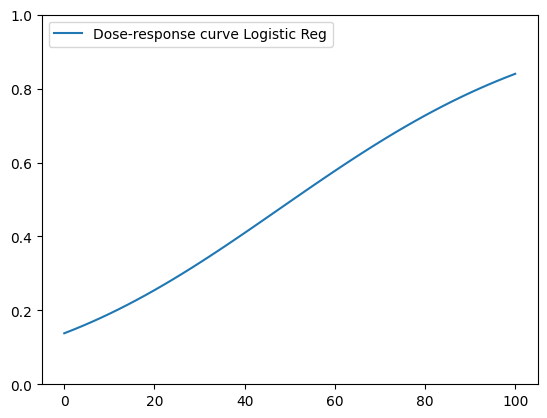

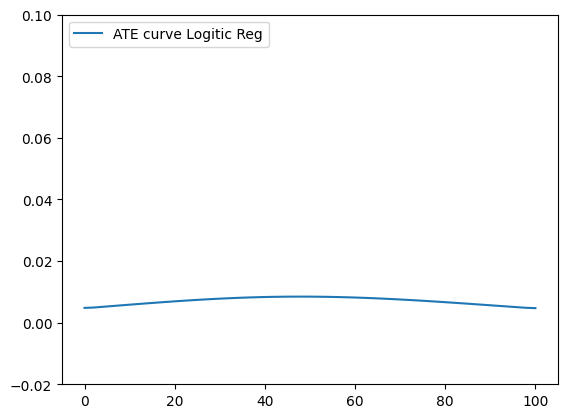

In [15]:
features_ate = [c for c in test if c != OUTCOME]

dose_response_data = average_dose_response_curve(
    df_eval=test,
    treatment_interventions=bin_edges,
    predictive_model=model_logit, 
    modelling_features=features_regression, 
    feature_counterfactual=TREATMENT, 
    model_package="statsmodels",
    task="classification"
)
ate_curve_data = np.gradient(dose_response_data, bin_edges)

plt.plot(bin_edges, dose_response_data, label="Dose-response curve Logistic Reg")
plt.legend(loc="upper left")
plt.ylim(0, 1)
plt.show()


plt.plot(bin_edges, ate_curve_data, label="ATE curve Logitic Reg")
plt.legend(loc="upper left")
plt.ylim(-0.02, 0.1)
plt.show()

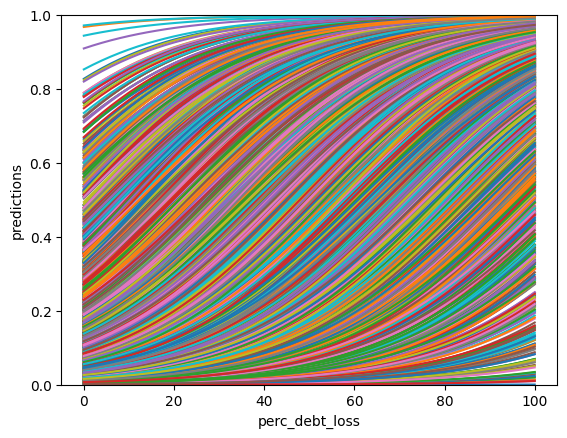

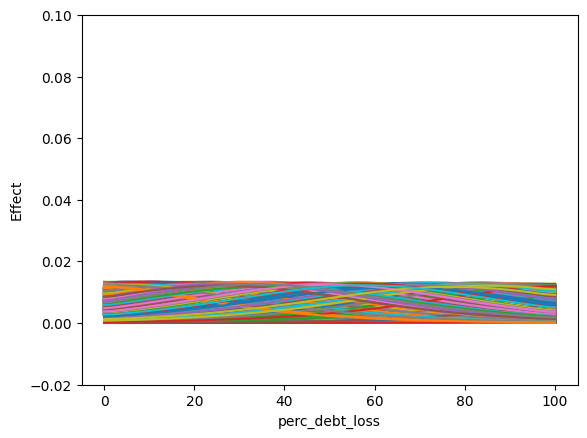

In [16]:
dose_response_data = individual_dose_response_curve(
    df_eval=test,
    treatment_interventions=bin_edges,
    predictive_model=model_logit, 
    modelling_features=features_regression, 
    feature_counterfactual=TREATMENT, 
    model_package="statsmodels",
    task="classification"
)
for i, line in enumerate(dose_response_data):
    ax = plt.plot(bin_edges, line, label=f'Line {i+1}')
plt.xlabel(TREATMENT)
plt.ylabel("predictions")
plt.ylim(0, 1)
plt.show()


for i, line in enumerate(dose_response_data):
    ite_curve_data = np.gradient(line, bin_edges)
    ax = plt.plot(bin_edges, ite_curve_data, label=f'Line {i+1}')
plt.xlabel(TREATMENT)
plt.ylabel("Effect")
plt.ylim(-0.02, 0.1)
plt.show()

## S-learner

In [17]:
init_params = {
    "n_estimators": 200,
    "depth": None,
    "min_data_in_leaf": round(X_train_propagated.shape[0]*0.01),
    "learning_rate": 0.01,
    "subsample": 1,
    "rsm": 1,
    "objective": "Logloss",
    "silent": True,
    "l2_leaf_reg": 3
}
init_params["monotone_constraints"] = monotone_constraints_list
s_learner = CatBoostClassifier(**init_params)
s_learner.fit(
    X_train_propagated[controls + outcome_causes + [TREATMENT]].copy().to_numpy(), 
    y_train_propagated.to_numpy(),
    #sample_weight=X_train_propagated["sample_weights"].to_numpy(),
)

print("Train")
get_metrics(X_train[controls + outcome_causes +[TREATMENT]], y_train, s_learner)
print("")

print("Test")
get_metrics(X_test[controls + outcome_causes + [TREATMENT]], y_test, s_learner)
print("")

Train
AUC: 0.76
Accuracy: 0.65
F1: 0.72
recall: 0.89
precision: 0.60

Test
AUC: 0.74
Accuracy: 0.66
F1: 0.71
recall: 0.85
precision: 0.61



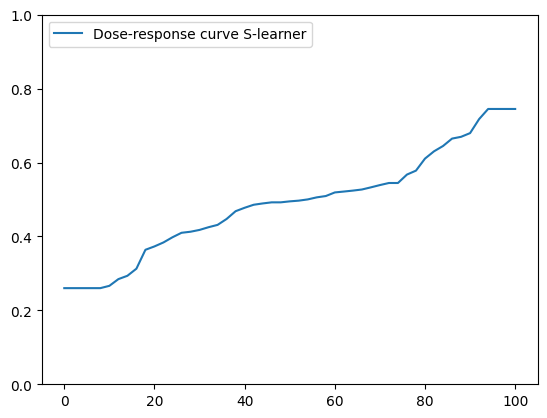

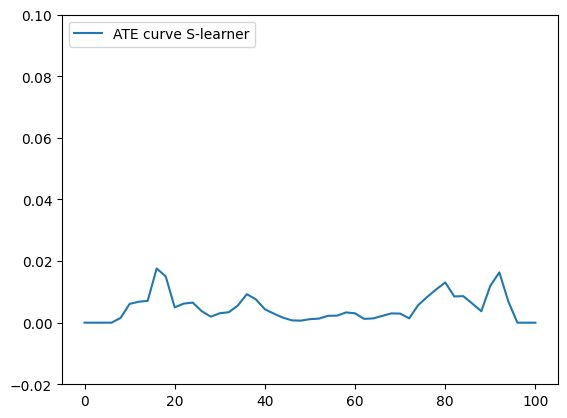

In [18]:
features_ate = [c for c in df if c != OUTCOME]

dose_response_data = average_dose_response_curve(
    df_eval=test,
    treatment_interventions=bin_edges,
    predictive_model=s_learner, 
    modelling_features=features_ate, 
    feature_counterfactual=TREATMENT, 
    model_package="sklearn",
    task="classification"
)
ate_curve_data = np.gradient(dose_response_data, bin_edges)

plt.plot(bin_edges, dose_response_data, label="Dose-response curve S-learner")
plt.legend(loc="upper left")
plt.ylim(0, 1)
plt.show()


plt.plot(bin_edges, ate_curve_data, label="ATE curve S-learner")
plt.legend(loc="upper left")
plt.ylim(-0.02, 0.1)
plt.show()

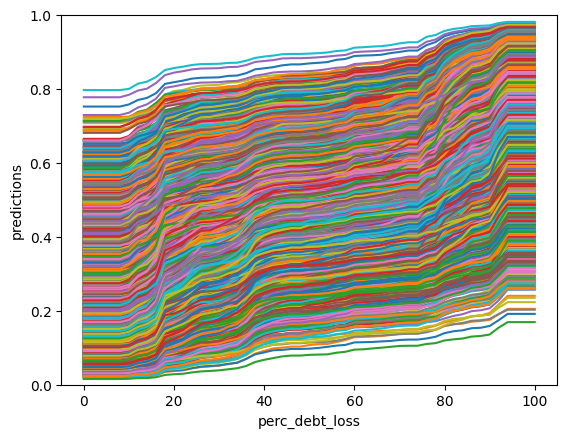

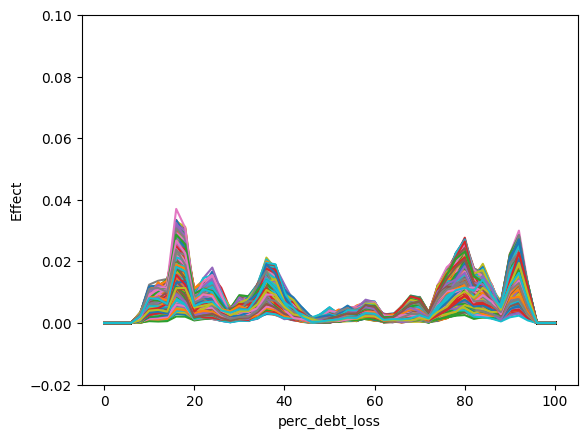

In [19]:
dose_response_data = individual_dose_response_curve(
    df_eval=test,
    treatment_interventions=bin_edges,
    predictive_model=s_learner, 
    modelling_features=X_train.columns, 
    feature_counterfactual=TREATMENT, 
    model_package="sklearn",
    task="classification"
)
for i, line in enumerate(dose_response_data):
    ax = plt.plot(bin_edges, line, label=f'Line {i+1}')
plt.xlabel(TREATMENT)
plt.ylabel("predictions")
plt.ylim(0, 1)
plt.show()


for i, line in enumerate(dose_response_data):
    ite_curve_data = np.gradient(line, bin_edges)
    ax = plt.plot(bin_edges, ite_curve_data, label=f'Line {i+1}')
plt.xlabel(TREATMENT)
plt.ylabel("Effect")
plt.ylim(-0.02, 0.1)
plt.show()

## Augmented IPTW

In [20]:
init_params = {
    "n_estimators": 200,
    "depth": None,
    "min_data_in_leaf": round(X_train.shape[0]*(2/3)*0.01),
    "learning_rate": 0.01,
    "subsample": 1,
    "rsm": 1,
    "objective": "RMSE",
    "silent": True,
    "l2_leaf_reg": 3
}
model_propensity = CatBoostRegressor(**init_params)

step = 5
bin_edges_contained = np.arange(0, 100+step, step)
bin_edges_contained[0] = -1

weighter = ContinuousIPTW(model=model_propensity, n_folds=5, random_state=42)
# weights_iptw = weighter.compute_weights(X_train[controls], X_train[[TREATMENT]], bin_edges_contained)
weights_iptw_da = weighter.compute_weights(X_train_propagated[controls], X_train_propagated[[TREATMENT]], bin_edges_contained)

In [21]:
print(np.max(weights_iptw_da))
print(np.min(weights_iptw_da))
weights_iptw_da[:30]

23.832480105697257
0.5134535293670137


array([0.99669371, 0.54624078, 0.66338277, 1.37273455, 0.72704779,
       0.51353863, 0.55949789, 0.65112104, 0.56199488, 0.67872376,
       0.6012776 , 0.99570356, 0.51568546, 1.07895101, 0.51480523,
       0.61281556, 0.6826064 , 0.51965152, 0.56333524, 0.86945476,
       1.10512945, 0.52254432, 0.55084651, 0.54456218, 0.57748821,
       0.60720924, 1.0508848 , 0.51348202, 0.62634174, 0.51730622])

In [22]:
init_params = {
    "n_estimators": 200,
    "depth": None,
    "min_data_in_leaf": round(X_train_propagated.shape[0]*0.01),
    "learning_rate": 0.01,
    "subsample": 1,
    "rsm": 1,
    "objective": "Logloss",
    "silent": True,
    "l2_leaf_reg": 3
}
init_params["monotone_constraints"] = monotone_constraints_list
extimator_aiptw = CatBoostClassifier(**init_params)
extimator_aiptw.fit(
    X_train_propagated[controls + outcome_causes + [TREATMENT]].copy().to_numpy(), 
    y_train_propagated.to_numpy(),
    sample_weight=weights_iptw_da,
)


print("Train")
get_metrics(X_train[controls + outcome_causes + [TREATMENT]], y_train, extimator_aiptw)
print("")

print("Test")
get_metrics(X_test[controls + outcome_causes + [TREATMENT]], y_test, extimator_aiptw)
print("")

Train
AUC: 0.75
Accuracy: 0.66
F1: 0.72
recall: 0.87
precision: 0.60

Test
AUC: 0.74
Accuracy: 0.64
F1: 0.71
recall: 0.89
precision: 0.59



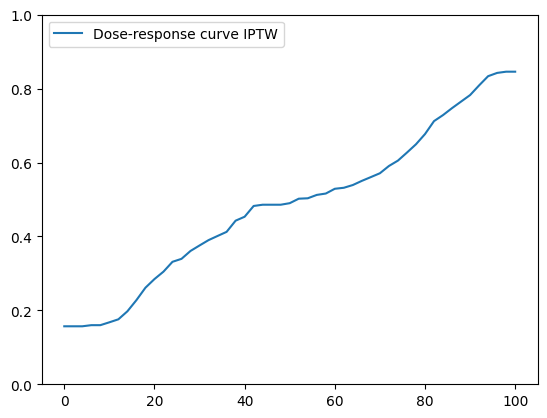

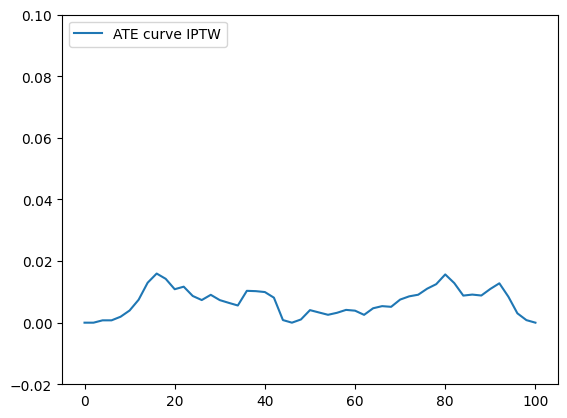

In [23]:
features_ate = [c for c in df if c != OUTCOME]

dose_response_data = average_dose_response_curve(
    df_eval=test,
    treatment_interventions=bin_edges,
    predictive_model=extimator_aiptw, 
    modelling_features=features_ate, 
    feature_counterfactual=TREATMENT, 
    model_package="sklearn",
    task="classification"
)
ate_curve_data = np.gradient(dose_response_data, bin_edges)

plt.plot(bin_edges, dose_response_data, label="Dose-response curve IPTW")
plt.legend(loc="upper left")
plt.ylim(0, 1)
plt.show()


plt.plot(bin_edges, ate_curve_data, label="ATE curve IPTW")
plt.legend(loc="upper left")
plt.ylim(-0.02, 0.1)
plt.show()

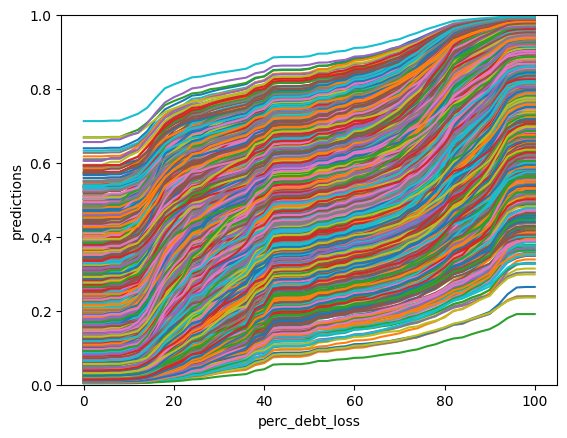

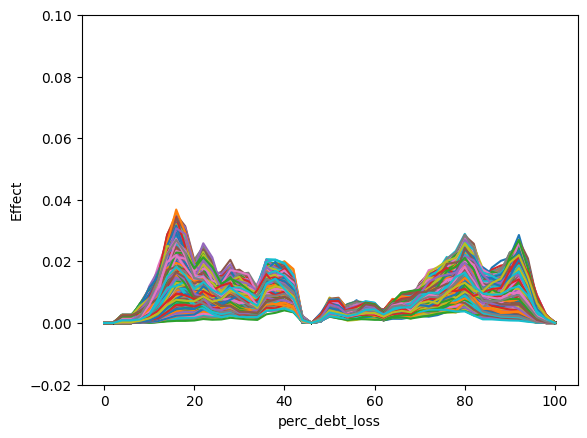

In [24]:
dose_response_data = individual_dose_response_curve(
    df_eval=test,
    treatment_interventions=bin_edges,
    predictive_model=extimator_aiptw, 
    modelling_features=X_train.columns, 
    feature_counterfactual=TREATMENT, 
    model_package="sklearn",
    task="classification"
)
for i, line in enumerate(dose_response_data):
    ax = plt.plot(bin_edges, line, label=f'Line {i+1}')
plt.xlabel(TREATMENT)
plt.ylabel("predictions")
plt.ylim(0, 1)
plt.show()


for i, line in enumerate(dose_response_data):
    ite_curve_data = np.gradient(line, bin_edges)
    ax = plt.plot(bin_edges, ite_curve_data, label=f'Line {i+1}')
plt.xlabel(TREATMENT)
plt.ylabel("Effect")
plt.ylim(-0.02, 0.1)
plt.show()

# Comparison

In [25]:
probs_table = pd.DataFrame(
    columns=[
        TREATMENT,
        "logistic_reg",
        "s_learner",
        "augmented_iptw",
    ]
)
probs_table[TREATMENT] = bin_edges

## Dose-response

In [26]:
features_modelling = controls +  outcome_causes + [TREATMENT]
for treatment_intervention in bin_edges:
    # data
    data_intervention = X_test.copy()
    data_intervention_binned = test.copy()
    data_intervention[TREATMENT] = treatment_intervention
    data_intervention_binned[TREATMENT] = treatment_intervention

    # predict
    predictions_reg = model_logit.predict(
        data_intervention_binned
    )
    predictions_s_learner = s_learner.predict_proba(data_intervention[features_modelling])[
        :, 1
    ]
    predictions_iptw = extimator_aiptw.predict_proba(data_intervention[features_modelling])[
        :, 1
    ]

    # P(Y | X, Z)
    probs_table.loc[probs_table[TREATMENT] == treatment_intervention, "logistic_reg"] = np.mean(
        predictions_reg
    )
    probs_table.loc[probs_table[TREATMENT] == treatment_intervention, "s_learner"] = np.mean(
        predictions_s_learner
    )
    probs_table.loc[probs_table[TREATMENT] == treatment_intervention, "augmented_iptw"] = (
        np.mean(predictions_iptw)
    )

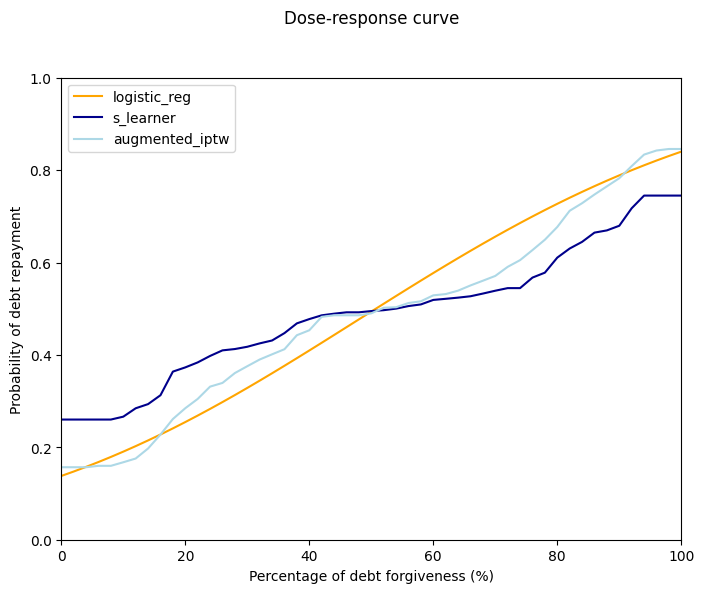

In [27]:
plt.figure(figsize=(8, 6))
for c, color in plot_ates.items():
    plt.plot(bin_edges, probs_table[c], label=c, color=color)
plt.xlabel("Percentage of debt forgiveness (%)")
plt.ylabel("Probability of debt repayment")
plt.title("Dose-response curve", y=1.1, x=0.5)
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, 100)
plt.show()

## Effect

In [28]:
ate_table = probs_table.copy()
for model_ate in plot_ates.keys():
    ate_table["causal_effect_curve_" + model_ate] = np.gradient(probs_table[model_ate], bin_edges)

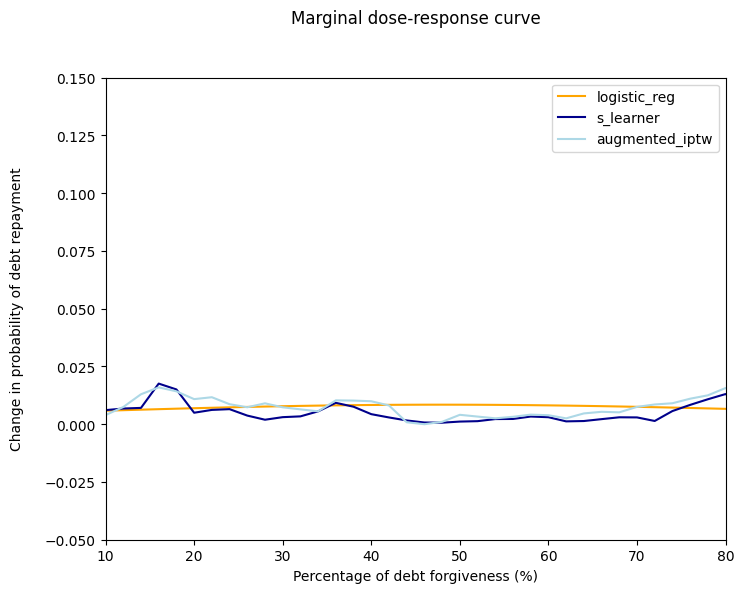

In [29]:
plt.figure(figsize=(8, 6))
for c, color in plot_ates.items():
    plt.plot(bin_edges, ate_table["causal_effect_curve_" + c], label=c, color=color)

plt.xlabel("Percentage of debt forgiveness (%)")
plt.ylabel(
    f"Change in probability of debt repayment",
    labelpad=15,
)
plt.title("Marginal dose-response curve", y=1.1, x=0.5)
plt.legend()
plt.xlim(10, 80)
plt.ylim(-0.05, 0.15)
plt.show()